5주차
===

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from PIL import Image as PILImage
from io import BytesIO

def notebook_dp_image(path: str, dim: set) -> None:
    img = PILImage.open(path)
    resized_img = img.resize(dim)  # (Width, Height)
    buffer = BytesIO()
    resized_img.save(buffer, format='PNG')
    display(Image(data=buffer.getvalue()))

_p147~187까지_

# 오차역전법

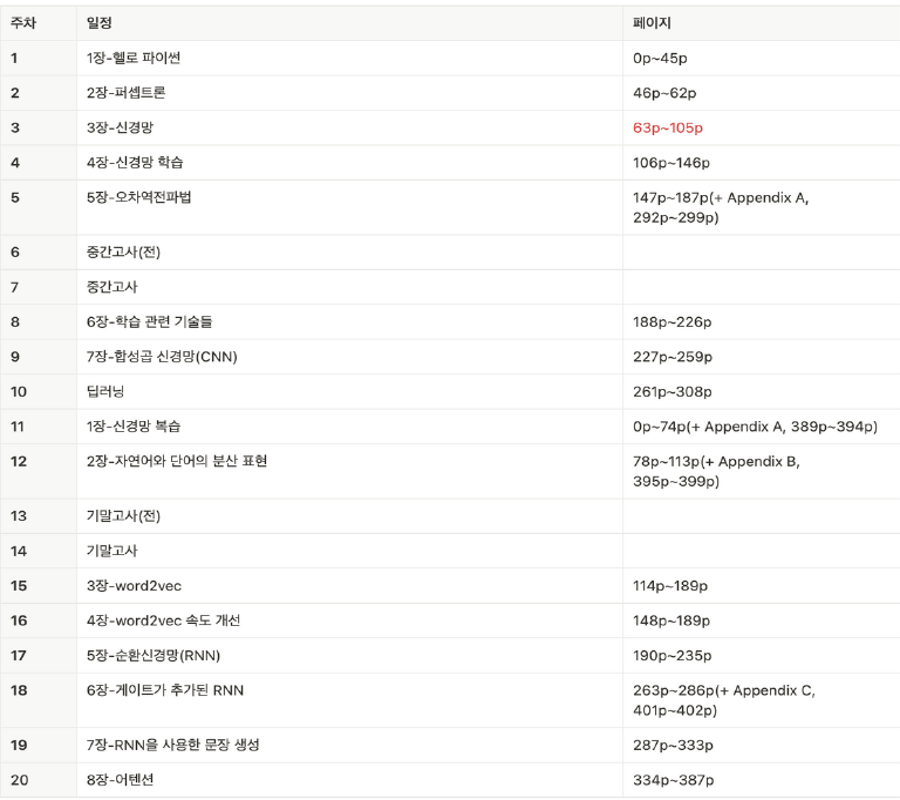

In [3]:
notebook_dp_image('./images/curriculum.png', (900,800))

---


## 역전파법

***TLDR;***

*합성함수에 들어가는 여러 변수중 한 변수가 최종 값에 미치는 영향을 계산/수치화 하기 위한 방법*

> 여기서 합성함수는 $\rightarrow f(g(h(x)))$ 같은 형태의 함수

> "한 변수"에 대하여만 계산한다는 것은 국소적 계산

> 영향을 계산/수치화: "한 변수"에 대하여 미분한다는 것

위의 모든것을 가능하게 해주는 것은 합성함수를 *계산 그래프*로  표현하는 것과 미분에서의 *연쇄법칙* 덕분에 가능 

#### 연쇄법칙과 (D)NN

다른거 안보고 안보고 그냥 바로 DNN에서 쓰이는 예시로 간다면... 우리는 <은닉층 안의 노드의 $w_{inp}$ 또는 $b_{inp}$>가 <최종 결과의 loss>에 미치는 영향을 알아보고자 한다.

<은닉층 안의 노드의 w 또는 b>는 보통 hyperparameter라 하니 $hp$라 하고 loss를 $l$이라고 한다면 우리가 찾고자 하는 값은 $\frac{\delta{l}}{\delta{hp}}$이라고 볼 수 있다.

이 NN에서 은닉층 3개로 구성되어 있다고 한다면 (각각 $f(x), g(x), h(x)$) 최종 output은 $h(g(f(x)))$인 합성함수, 활성함수인 $a(x)$와 손실함수 $L(x)$까지 포함하면: (a는 생략하고 output layer는 별도로 없다 하고)
$$
l = L(h(g(f(x_1, w_1, b_1, x_2, w_2, b_2, x_3, \cdots))))
$$

여기서 $w_1$에 대하여 미분을 한다고 하면...

$$
\frac{\delta{l}}{\delta{w_1}} = 
\frac{\delta{l}}{\delta{h}}\times
\frac{\delta{h}}{\delta{g}}\times
\frac{\delta{g}}{\delta{f}}\times
\frac{\delta{f}}{\delta{w_1}}
$$
단순화 좀 한 표현은 다음과 같음 (레이어별 sum/dot도 있고 loss함수 자체 미분값들도 있고 그래서 실제로는 좀 더 복잡)

---

이후 배울 Affine layer는 다음과 같음

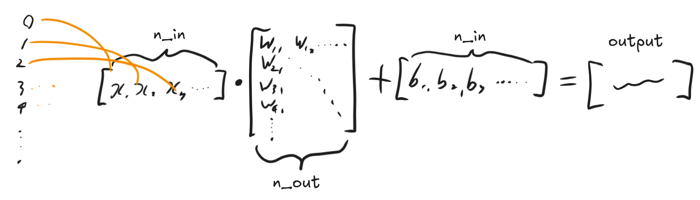

In [4]:
notebook_dp_image('./images/W5/img1.png', (700,200))

wx + b 표현한걸로 뭉쳐서 표현

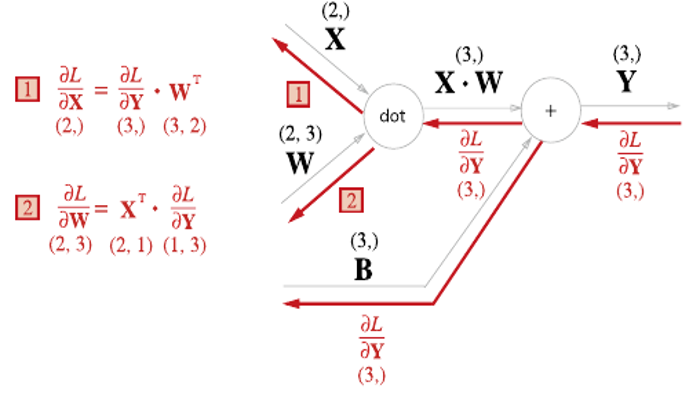

In [5]:
notebook_dp_image('./images/W5/img2.png', (700,400))

single sample Affine layer에 대한 미분은 위와 같다.

유도 과정 분해해보면:

$$
Y = X \cdot W
\\\text{}
\\
Y[i,j] = \sum_{k=1}^{d} X[i,k] \, W[k,j]
\\\text{}
\\
\frac{\partial Y[i,j]}{\partial X[i,k]} = W[k,j]
\\ \text{(X에 대하여 미분하면 Y의 값은 W에 직결되기에)}
\\\text{}
\\
\frac{\partial L}{\partial X[i,k]} = \sum_{j=1}^{n} \frac{\partial L}{\partial Y[i,j]} \cdot \frac{\partial Y[i,j]}{\partial X[i,k]}
\\\text{}
\\
\frac{\partial L}{\partial X[i,k]} = \sum_{j=1}^{n} \frac{\partial L}{\partial Y[i,j]} \, W[k,j].
\\ \text{(위의 식을 대입한다면)}
\\\text{}
\\
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T
\\ \text{((i, j)와 (k, j)곱하기 위해서 W를 transpose) } (W^T)_{jk}=W_{kj}
$$
(여기서 그냥 transpose해도 괜찮은건지...)

추가로...책에 나온 시그모이드 활성화함수 같은 경우는 순번파의 출력만을 통헤서 계산을 할 수 있다.

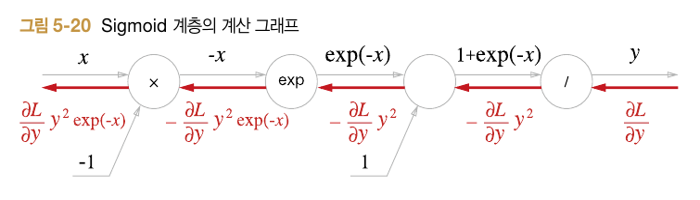

In [6]:
notebook_dp_image('./images/W5/img3.png', (700,200))

#### 추가 부록 (출력 및 손실함수 부분)
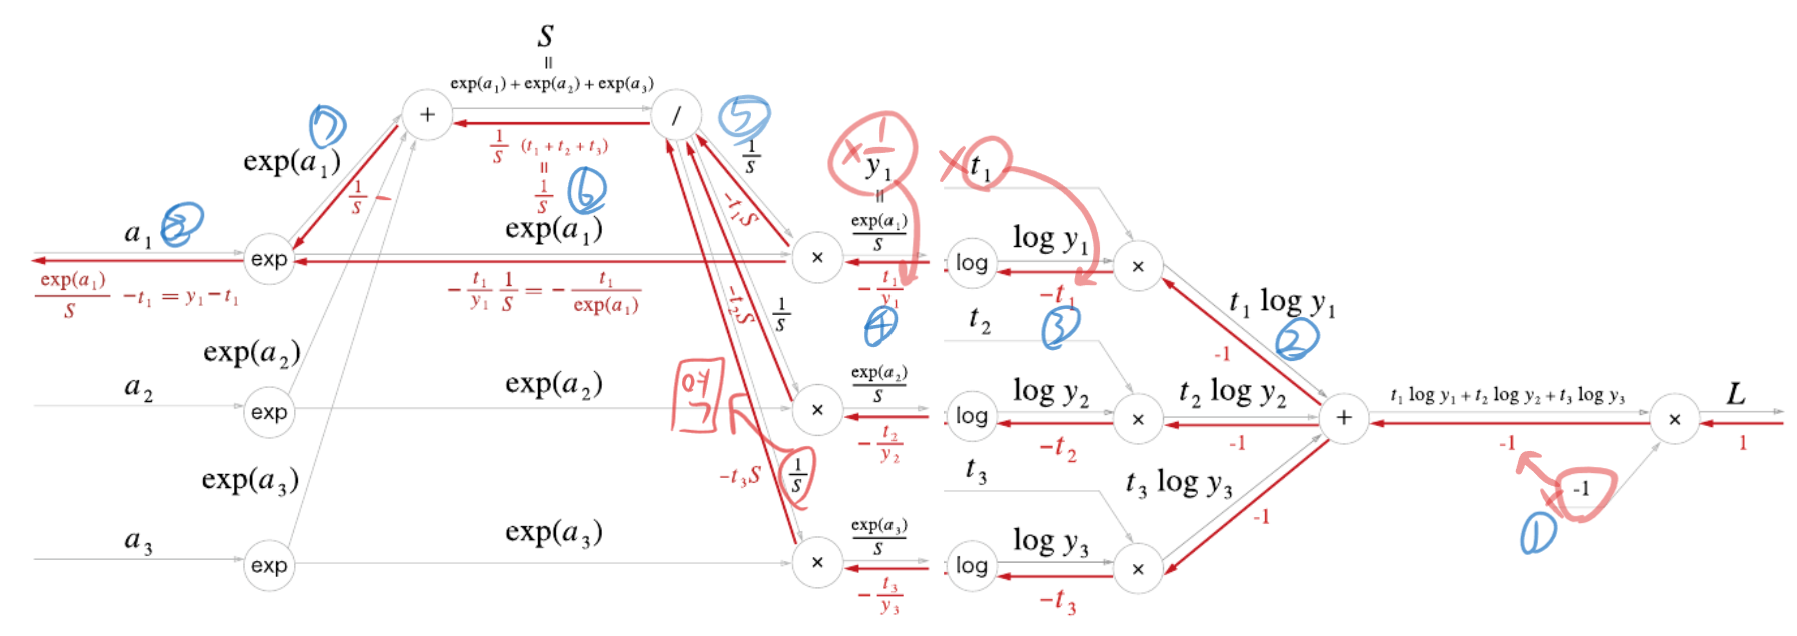

앞서 생략한다고 했던 출력층(softmax)와 손실함수분을 살펴본다면...
1. 옆 가지에서 $\times -1$
2. +는 패스
3. 옆 가지에서 $\times t_1$
4. $log(y_1)$ 미분하면 뒤집어까짐 $\frac{-t_1}{y_1}$
5. 옆가지는 내 자신, 이동중에 $\frac{1}{S}$당하므로 S곱해주기
6. $\frac{\sum{t}}{S}$하는데 t라벨링 자체가 one-hot이므로 $\sum{t}$이 1임. $\frac{1}{S}$로 넘기기
7. *이부분부터는 책도 설명이 자세하지 않아서 이해가 안됨...*
8. ...

## 오차역전법 구현하기

In [13]:
from tensorflow.keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.

x_train.shape

(60000, 784)

In [ ]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.p_p147arams['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'train acc: {train_acc},\ntest acc: {test_acc}\n', '='*10)

train acc: 0.1497,
test acc: 0.1551
train acc: 0.9048666666666667,
test acc: 0.9083
train acc: 0.9241166666666667,
test acc: 0.9258
train acc: 0.9363666666666667,
test acc: 0.9368
train acc: 0.9436,
test acc: 0.94
train acc: 0.9501333333333334,
test acc: 0.948
train acc: 0.9560166666666666,
test acc: 0.9525
train acc: 0.9592666666666667,
test acc: 0.9544
train acc: 0.95975,
test acc: 0.956
train acc: 0.9640833333333333,
test acc: 0.9607
train acc: 0.9677333333333333,
test acc: 0.9628
train acc: 0.9702166666666666,
test acc: 0.9648
train acc: 0.97155,
test acc: 0.9654
train acc: 0.9723,
test acc: 0.9655
train acc: 0.9755166666666667,
test acc: 0.968
train acc: 0.9757833333333333,
test acc: 0.9696
train acc: 0.9780833333333333,
test acc: 0.9703
